In [4]:
subtitle = '1-Year Price Projections (252 trading days, 1000 simulations)'
print(subtitle)

1-Year Price Projections (252 trading days, 1000 simulations)


In [6]:
try:
    import yfinance as yf
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance"])
    import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9,5)
plt.rcParams["axes.grid"] = True

  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached peewee-3.18.2-cp311-cp311-linux_x86_64.whl
  Using cached curl_cffi-0.13.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached websockets-15.0.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached yfinance-0.2.66-py2.py3-none-any.whl (123 kB)
Using cached curl_cffi-0.13.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached websockets-15.0.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (182 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [yfinance]4/5 [yfinance]]


In [7]:
import datetime as dt

ticker = "SPY"
end = dt.date.today()
start = end - dt.timedelta(days = 365*5)
trading_days = 252

data = yf.download(ticker, start = start, end = end, progress = False, auto_adjust = True)
prices = data["Close"].dropna()

logret = np.log(prices / prices.shift(1)).dropna()

mu_annual = logret.mean()*trading_days
sigma_annual = logret.std()*np.sqrt(trading_days)

mu_annual, sigma_annual

(Ticker
 SPY    0.147232
 dtype: float64,
 Ticker
 SPY    0.172263
 dtype: float64)

/tmp/ipykernel_251/3969926172.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.iloc[-1])


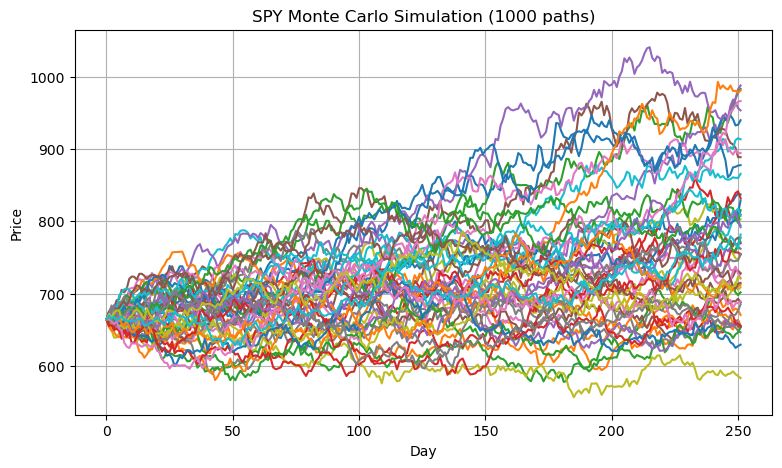

In [8]:
mu = float(mu_annual.squeeze())
sigma = float(mu_annual.squeeze())

S0 = float(prices.iloc[-1])
T = 1
N = 252
dt = T/N
num_sims = 1000

Z = np.random.standard_normal((N, num_sims))

paths = np.zeros((N, num_sims), dtype = float)
paths[0, :] = S0

for t in range(1, N):
    paths[t, :] = paths[t-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + 
                                 sigma * np.sqrt(dt) * Z[t, :])

plt.plot(paths[:, :50])
plt.title(f"{ticker} Monte Carlo Simulation ({num_sims} paths)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.show()

In [6]:
caption1 = "Geometric Brownian motion terminal price projections for SPY, using annualized σ and μ estimates calculated from the preceding 5 years of daily returns. Each line represents a possible return path over 1 year, and the distribution of the price paths shows the dispersion implied by the estimated volatility of the underlying. Next I'll aggregate the 1-year terminal prices into a frequency distribution to create a cleaner visual of significant percentile and median paths."
print(caption1)

Geometric Brownian motion terminal price projections for SPY, using annualized σ and μ estimates calculated from the preceding 5 years of daily returns. Each line represents a possible return path over 1 year, and the distribution of the price paths shows the dispersion implied by the estimated volatility of the underlying. Next I'll aggregate the 1-year terminal prices into a frequency distribution to create a cleaner visual of significant percentile and median paths.


In [9]:
terminal = paths[-1, :]

exp_end = terminal.mean()
median_end = np.median(terminal)
pctl_5, pctl_25, pctl_75, pctl_95 = np.percentile(terminal, [5, 25, 75, 95])

prob_up = (terminal > S0).mean()
prob_down10 = (terminal < 0.9 * S0).mean()
prob_up10 = (terminal > 1.1 * S0).mean()

exp_end, median_end, (pctl_5, pctl_25, pctl_75, pctl_95), prob_up, prob_up10, prob_down10

(np.float64(770.5577449424239),
 np.float64(759.5412437398951),
 (np.float64(614.2229805596133),
  np.float64(694.6679561147571),
  np.float64(834.6798200991219),
  np.float64(966.7888985906994)),
 np.float64(0.839),
 np.float64(0.618),
 np.float64(0.038))

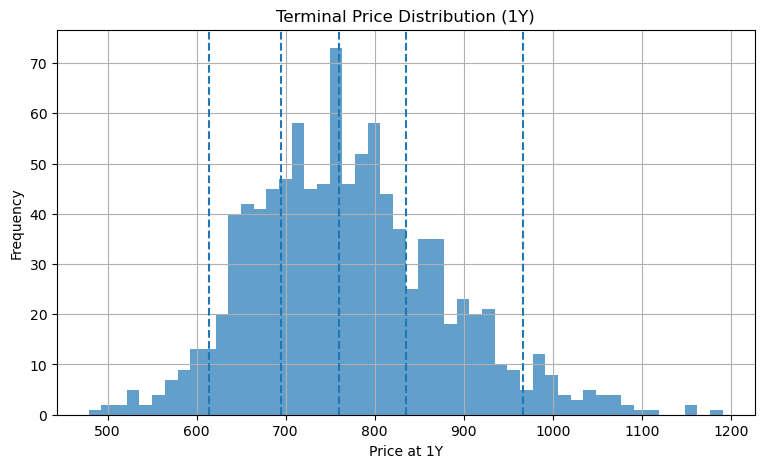

In [10]:
plt.hist(terminal, bins = 50, alpha = 0.7)
for v in [pctl_5, pctl_25, median_end, pctl_75, pctl_95]:
    plt.axvline(v, linestyle = "--")
plt.title("Terminal Price Distribution (1Y)")
plt.xlabel("Price at 1Y")
plt.ylabel("Frequency")
plt.show()

Expected return:  15.98%
Median return:    14.32%
5th–95th pct band: -7.55%  →  45.52%


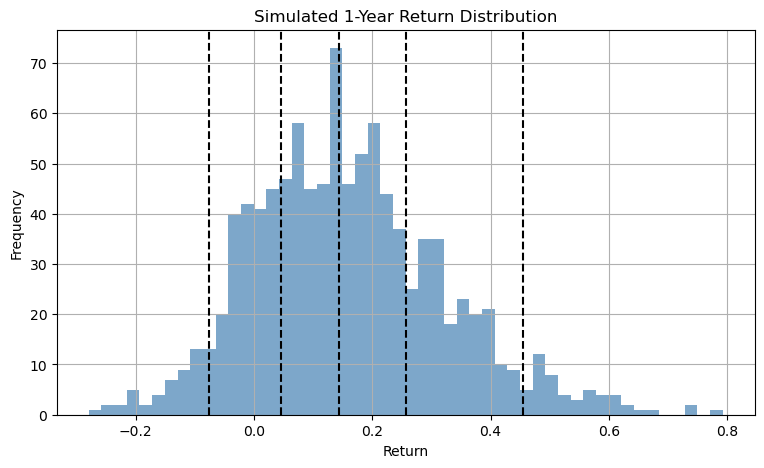

In [11]:
returns = (terminal / S0) - 1

exp_ret = returns.mean()
median_ret = np.median(returns)
p5, p25, p75, p95 = np.percentile(returns, [5, 25, 75, 95])

print(f"Expected return:  {exp_ret:.2%}")
print(f"Median return:    {median_ret:.2%}")
print(f"5th–95th pct band: {p5:.2%}  →  {p95:.2%}")

plt.hist(returns, bins=50, alpha=0.7, color="steelblue")
for v in [p5, p25, median_ret, p75, p95]:
    plt.axvline(v, linestyle="--", color="black")
plt.title("Simulated 1-Year Return Distribution")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

In [11]:
caption2 = "This histogram displays the distribution of 1-year SPY simulated returns, with dashed lines at the median, 5th, 25th, 75th, and 95th percentiles. The median return is about +14%, with a 5th-95th percentile band of about -7.5% to +45%. I'll use this percentile interval to plot a cleaner chart of the Monte Carlo simulated returns with less noise."
print(caption2)

This histogram displays the distribution of 1-year SPY simulated returns, with dashed lines at the median, 5th, 25th, 75th, and 95th percentiles. The median return is about +14%, with a 5th-95th percentile band of about -7.5% to +45%. I'll use this percentile interval to plot a cleaner chart of the Monte Carlo simulated returns with less noise.


In [14]:
!pip install xlsxwriter

In [15]:
summary = pd.DataFrame({
    "S0": [S0],
    "Expected_End_Price": [terminal.mean()],
    "Median_End_Price": [np.median(terminal)],
    "Exp_Return": [returns.mean()],
    "Median_Return": [np.median(returns)],
    "P5_Return": [np.percentile(returns, 5)],
    "P25_Return": [np.percentile(returns, 25)],
    "P75_Return": [np.percentile(returns, 75)],
    "P95_Return": [np.percentile(returns, 95)],
    "Prob_Up": [(terminal > S0).mean()],
    "Prob_Down_10pct": [(terminal < 0.9 * S0).mean()],
    "Prob_Up_10pct": [(terminal > 1.1 * S0).mean()]
})

qs = [5, 25, 50, 75, 95]
bands = np.percentile(paths, qs, axis=1)
bands_df = pd.DataFrame(bands.T, columns=[f"p{q}" for q in qs])
bands_df.insert(0, "day", np.arange(paths.shape[0]))
bands_df["mean"] = paths.mean(axis=1)

sample_cols = min(100, paths.shape[1])
paths_sample = pd.DataFrame(paths[:, :sample_cols])
paths_sample.insert(0, "day", np.arange(paths.shape[0]))

terminal_df = pd.DataFrame({"terminal_price": terminal, "terminal_return": returns})

out_xlsx = f"mc_{ticker}_1y.xlsx"
with pd.ExcelWriter(out_xlsx, engine="xlsxwriter") as writer:
    summary.to_excel(writer, sheet_name="summary", index=False)
    bands_df.to_excel(writer, sheet_name="percentile_bands", index=False)
    paths_sample.to_excel(writer, sheet_name="paths_sample", index=False)
    terminal_df.to_excel(writer, sheet_name="terminal_dist", index=False)

summary.to_csv(f"mc_{ticker}_summary.csv", index=False)
bands_df.to_csv(f"mc_{ticker}_bands.csv", index=False)
terminal_df.to_csv(f"mc_{ticker}_terminal.csv", index=False)

out_xlsx

'mc_SPY_1y.xlsx'

In [16]:
caption3 = "These are the simplified percentile and mean paths from the SPY Monte Carlo simulation. They create a cone containing the middle 90% of simulated 1-year returns, and can be used to estimate price trends under different assumptions. The width and angle of the cone roughly measure the price dispersion implied by volatility and drift, respectively. This model uses geometric Brownian motion with σ and μ estimated from the last 5 years of daily returns."
print(caption3)

These are the simplified percentile and mean paths from the SPY Monte Carlo simulation. They create a cone containing the middle 90% of simulated 1-year returns, and can be used to estimate price trends under different assumptions. The width and angle of the cone roughly measure the price dispersion implied by volatility and drift, respectively. This model uses geometric Brownian motion with σ and μ estimated from the last 5 years of daily returns.
